### Vector Autoregression

Notebook for producing a Vector Autoregression models in forecasting E. coli levels.

In [13]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import sys
import pprint
import shap
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
import matplotlib.dates as mdates

from statsmodels.tsa.vector_ar.var_model import VAR
from tqdm.notebook import tqdm
from utils import *
from data import *

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
SEED = 64

log_scale_microbial_feats = True

model_name = 'default'
if log_scale_microbial_feats:
    model_name = 'log_scaled_microbial_feats'
    
data_folder = '../data/cleanedFiles/'
img_path = '../data/output/' + model_name + '/'
target_label = 'ecoli_lab_LAE'

train_start = '2012-04-03' # 5.5 Years of Training
train_end = '2017-10-30'
test_start = '2017-10-31' # 2 Years of Testing
test_end = '2019-10-30'

if not os.path.exists(img_path):
    os.makedirs(img_path)
    
if not os.path.exists(img_path + 'VAR'):
    os.makedirs(img_path + 'VAR')


In [15]:
# Read Data.

df = read_ecoli_lab('ecoli_LAE', log_scale_microbial_feats)
df = df.join(read_ecoli_lab('ecoli_GA', log_scale_microbial_feats))

df = df.join(read_ecoli_colifast('colifast_LAE'))
df = df.join(read_ecoli_colifast('colifast_GA'))

df = df.join(read_precipitation('precipitation_GBG', False))
df = df.join(read_precipitation('precipitation_VB', True))
df = df.join(read_precipitation('precipitation_KR', True))

df = df.join(read_water_temp('waterTemp_LAE'))

df = df.join(read_flow_rate('flowrate_LE'))
df = df.join(read_flow_rate('flowrate_GG'))

#df = df.join(read_water_level('waterLevel_TOR'))

df = df.join(read_turbidity('turb_LAE'))

df = df.join(read_coliforms('coliforms_LAE', log_scale_microbial_feats))
df = df.join(read_coliforms('coliforms_GA', log_scale_microbial_feats))

display(df)

,ecoli_lab_LAE,ecoli_lab_GA,ecoli_colifast_LAE_1st,ecoli_colifast_LAE_2nd,ecoli_colifast_GA_1st,ecoli_colifast_GA_2nd,precipitation_GBG,precipitation_VB,precipitation_KR,waterTemp_LAE,flowrate_LE,flowrate_GG,turb_LAE,coliforms_LAE,coliforms_GA
2012-01-02,5.398163,5.252273,2.0,3.0,NaN,NaN,0.5,3.7,2.5,4.8,880,220,7.1,6.478510,6.647688
2012-01-03,NaN,NaN,3.0,3.0,NaN,NaN,21.3,16.9,28.0,NaN,853,213,NaN,NaN,NaN
2012-01-04,5.707110,6.255750,4.0,1.0,NaN,NaN,7.0,0.5,6.4,4.9,785,196,8.5,6.660575,7.244942
2012-01-05,5.739793,6.274762,5.0,6.0,NaN,NaN,0.2,0.1,0.0,4.7,882,221,31.2,7.313887,7.313887
2012-01-06,NaN,NaN,5.0,5.0,NaN,NaN,0.0,0.0,0.0,NaN,879,220,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,5.017280,4.875197,2.0,1.0,2.0,2.0,NaN,NaN,NaN,4.6,591,148,5.3,5.739793,5.739793
2019-12-27,5.081404,NaN,1.0,1.0,1.0,2.0,NaN,NaN,NaN,4.2,655,164,5.4,5.968708,NaN
2019-12-28,NaN,NaN,2.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,847,212,NaN,NaN,NaN
2019-12-29,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,829,207,NaN,NaN,NaN


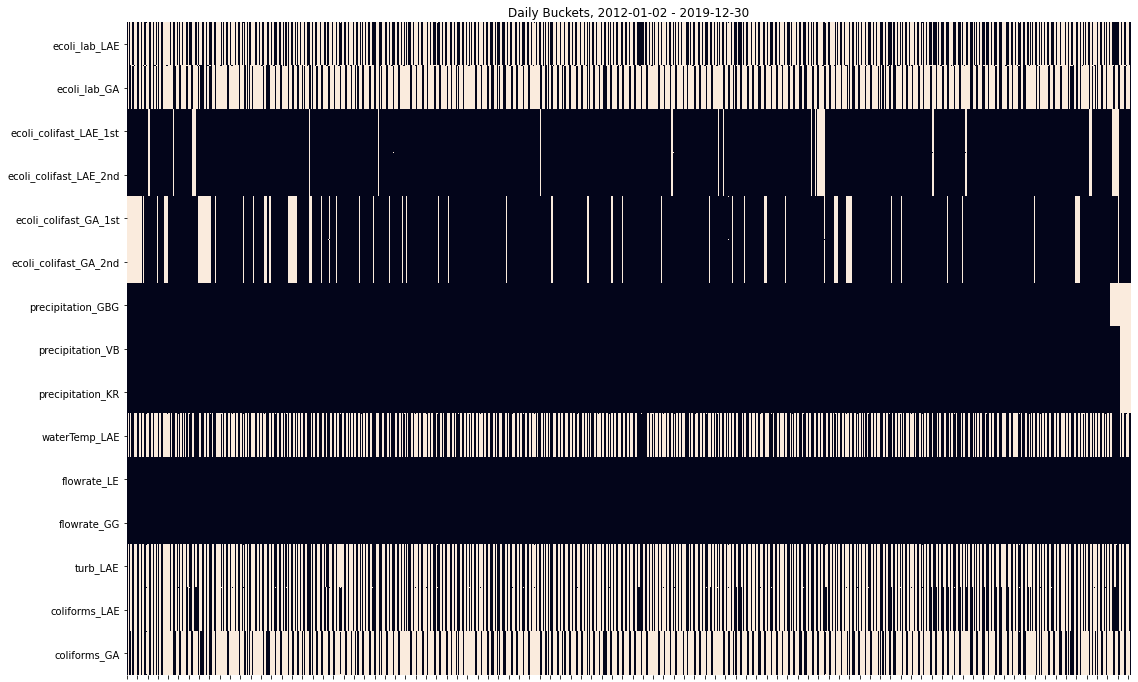

In [16]:
# Check NaN

plt.figure(figsize=(18,12), facecolor='w')
ax = sns.heatmap(df.transpose().isnull(), cbar=False)
ax.set(xticklabels=[])
plt.title('Daily Buckets, ' + df.index[0].strftime('%Y-%m-%d') + ' - ' + df.index[-1].strftime('%Y-%m-%d'))
#plt.savefig(img_path + 'missing_values.png', bbox_inches='tight', transparent=False)
plt.show()

In [17]:
# Data Imputation.

df_feat = df.copy()

print(df_feat.shape)
print(df_feat.isnull().any(axis=1).sum())
print(df_feat.isnull().sum())
print('')

display(df_feat)

null_idx = df_feat[df_feat[target_label].isnull()].index
df_feat = df_feat.interpolate(method='pad')

display(df_feat)

(2920, 15)
2489
ecoli_lab_LAE             1630
ecoli_lab_GA              1996
ecoli_colifast_LAE_1st     118
ecoli_colifast_LAE_2nd     118
ecoli_colifast_GA_1st      300
ecoli_colifast_GA_2nd      300
precipitation_GBG           60
precipitation_VB            30
precipitation_KR            30
waterTemp_LAE             1520
flowrate_LE                  0
flowrate_GG                  0
turb_LAE                  1674
coliforms_LAE             1589
coliforms_GA              1983
dtype: int64



,ecoli_lab_LAE,ecoli_lab_GA,ecoli_colifast_LAE_1st,ecoli_colifast_LAE_2nd,ecoli_colifast_GA_1st,ecoli_colifast_GA_2nd,precipitation_GBG,precipitation_VB,precipitation_KR,waterTemp_LAE,flowrate_LE,flowrate_GG,turb_LAE,coliforms_LAE,coliforms_GA
2012-01-02,5.398163,5.252273,2.0,3.0,NaN,NaN,0.5,3.7,2.5,4.8,880,220,7.1,6.478510,6.647688
2012-01-03,NaN,NaN,3.0,3.0,NaN,NaN,21.3,16.9,28.0,NaN,853,213,NaN,NaN,NaN
2012-01-04,5.707110,6.255750,4.0,1.0,NaN,NaN,7.0,0.5,6.4,4.9,785,196,8.5,6.660575,7.244942
2012-01-05,5.739793,6.274762,5.0,6.0,NaN,NaN,0.2,0.1,0.0,4.7,882,221,31.2,7.313887,7.313887
2012-01-06,NaN,NaN,5.0,5.0,NaN,NaN,0.0,0.0,0.0,NaN,879,220,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,5.017280,4.875197,2.0,1.0,2.0,2.0,NaN,NaN,NaN,4.6,591,148,5.3,5.739793,5.739793
2019-12-27,5.081404,NaN,1.0,1.0,1.0,2.0,NaN,NaN,NaN,4.2,655,164,5.4,5.968708,NaN
2019-12-28,NaN,NaN,2.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,847,212,NaN,NaN,NaN
2019-12-29,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,829,207,NaN,NaN,NaN


,ecoli_lab_LAE,ecoli_lab_GA,ecoli_colifast_LAE_1st,ecoli_colifast_LAE_2nd,ecoli_colifast_GA_1st,ecoli_colifast_GA_2nd,precipitation_GBG,precipitation_VB,precipitation_KR,waterTemp_LAE,flowrate_LE,flowrate_GG,turb_LAE,coliforms_LAE,coliforms_GA
2012-01-02,5.398163,5.252273,2.0,3.0,NaN,NaN,0.5,3.7,2.5,4.8,880,220,7.1,6.478510,6.647688
2012-01-03,5.398163,5.252273,3.0,3.0,NaN,NaN,21.3,16.9,28.0,4.8,853,213,7.1,6.478510,6.647688
2012-01-04,5.707110,6.255750,4.0,1.0,NaN,NaN,7.0,0.5,6.4,4.9,785,196,8.5,6.660575,7.244942
2012-01-05,5.739793,6.274762,5.0,6.0,NaN,NaN,0.2,0.1,0.0,4.7,882,221,31.2,7.313887,7.313887
2012-01-06,5.739793,6.274762,5.0,5.0,NaN,NaN,0.0,0.0,0.0,4.7,879,220,31.2,7.313887,7.313887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,5.017280,4.875197,2.0,1.0,2.0,2.0,0.0,0.0,0.0,4.6,591,148,5.3,5.739793,5.739793
2019-12-27,5.081404,4.875197,1.0,1.0,1.0,2.0,0.0,0.0,0.0,4.2,655,164,5.4,5.968708,5.739793
2019-12-28,5.081404,4.875197,2.0,1.0,2.0,1.0,0.0,0.0,0.0,4.2,847,212,5.4,5.968708,5.739793
2019-12-29,5.081404,4.875197,1.0,1.0,1.0,1.0,0.0,0.0,0.0,4.2,829,207,5.4,5.968708,5.739793


In [18]:
# Data Split.

train_idx = df_feat.loc[(df_feat.index >= train_start) & (df_feat.index <= train_end)].index
test_idx = df_feat.loc[(df_feat.index >= test_start) & (df_feat.index <= test_end)].index


In [19]:
# Fit VAR models and estimate best lag order.

var_model = VAR(df_feat.loc[train_idx]).fit(maxlags=15, ic='aic')

print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 29, Oct, 2020
Time:                     10:10:08
--------------------------------------------------------------------
No. of Equations:         15.0000    BIC:                    18.1158
Nobs:                     2033.00    HQIC:                   16.5151
Log likelihood:          -58200.3    FPE:                5.88467e+06
AIC:                      15.5876    Det(Omega_mle):     3.77687e+06
--------------------------------------------------------------------
Results for equation ecoli_lab_LAE
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             1.390175         0.188148            7.389           0.000
L1.ecoli_lab_LAE                  0.694746         0.029584           23.484           0.000
L1.e

In [20]:
# Perform evaluation on train and test data.

train_dates = []
test_dates = []

y_train = []
y_test = []

var_y_train = []
var_y_test = []

for idx in tqdm(range(var_model.k_ar+1, df_feat.shape[0])):
    
    date_idx = df_feat.index[idx]

    if date_idx not in null_idx:
        #print(df_feat.iloc[idx-var_model.k_ar:idx, :])
        var_forecast = var_model.forecast(
            y=df_feat.iloc[idx-var_model.k_ar:idx, :].values,
            steps=1
        )[0]

        if date_idx in train_idx:
            train_dates.append(date_idx)
            y_train.append(df_feat.loc[date_idx, target_label])
            var_y_train.append(var_forecast[0])
        elif date_idx in test_idx:
            test_dates.append(date_idx)
            y_test.append(df_feat.loc[date_idx, target_label])
            var_y_test.append(var_forecast[0])

train_dates = np.array(train_dates)
test_dates = np.array(test_dates)
y_train = np.array(y_train)
y_test = np.array(y_test)
var_y_train = np.array(var_y_train)
var_y_test = np.array(var_y_test)


In [21]:
# Save Observations and Predictions.

pd.DataFrame({
    'ds': train_dates,
    'observation': y_train,
    'prediction': var_y_train
}).to_csv(
    img_path + 'VAR/train_predictions.csv',
    index=False
)

pd.DataFrame({
    'ds': test_dates,
    'observation': y_test,
    'prediction': var_y_test
}).to_csv(
    img_path + 'VAR/test_predictions.csv',
    index=False
)


In [22]:
# Show Performance.

print('\nTrain Metrics')

var_performance = obtain_performance('VAR', y_train, var_y_train)

df_train_eval = pd.DataFrame(columns=['Model', 'MAE', 'SMAPE', 'RMSE', 'R2'])
df_train_eval = df_train_eval.append(var_performance, ignore_index=True)

df_train_eval.to_csv(
    img_path + 'var_train_metrics.csv',
    index=False
)

s = df_train_eval.style.hide_index()
s = s.apply(highlight_cells)
display(s)

dfi.export(s, img_path + 'var_train_metrics.png')


print('\nTest Metrics')

var_performance = obtain_performance('VAR', y_test, var_y_test)

df_test_eval = pd.DataFrame(columns=['Model', 'MAE', 'SMAPE', 'RMSE', 'R2'])
df_test_eval = df_test_eval.append(var_performance, ignore_index=True)

df_test_eval.to_csv(
    img_path + 'var_test_metrics.csv',
    index=False
)

s = df_test_eval.style.hide_index()
s = s.apply(highlight_cells)
display(s)

dfi.export(s, img_path + 'var_test_metrics.png')



Train Metrics


Model,MAE,SMAPE,RMSE,R2
VAR,0.561707,14.285388,0.753357,0.538091



Test Metrics


Model,MAE,SMAPE,RMSE,R2
VAR,0.557768,13.508730,0.747560,0.533770


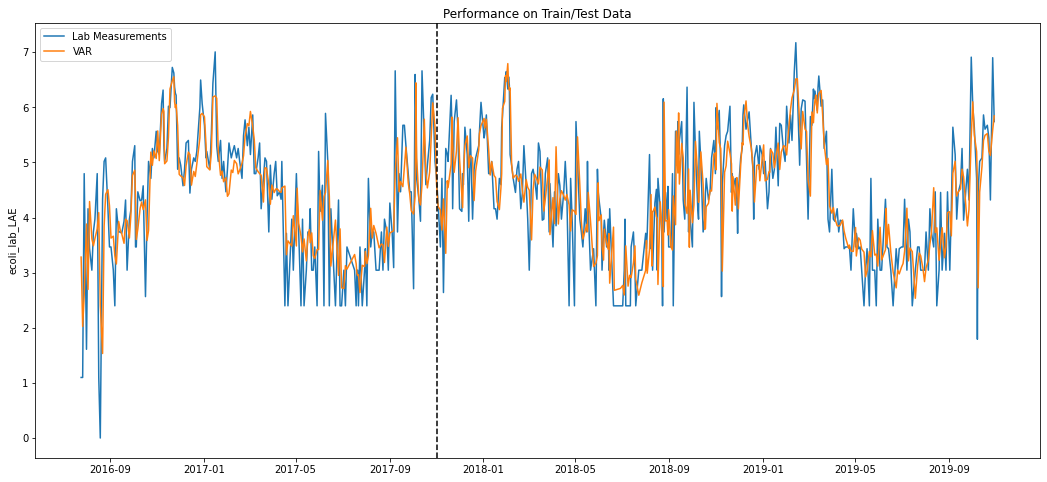

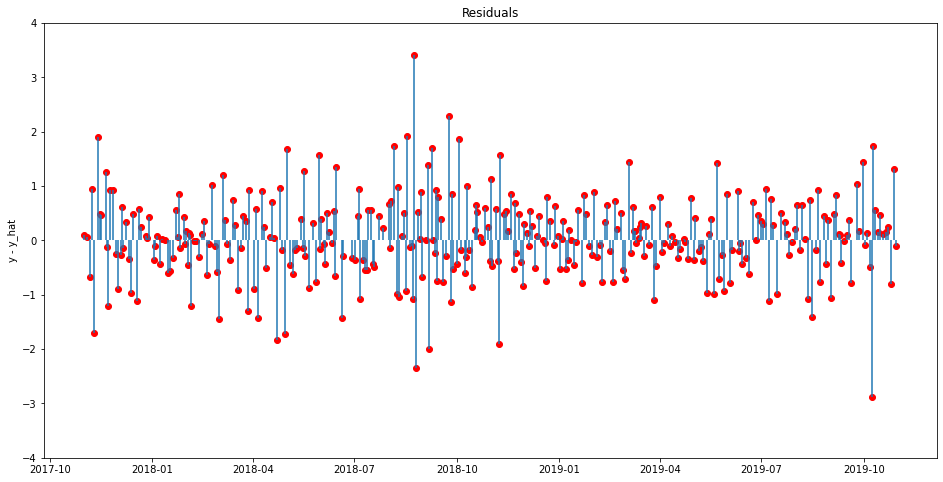

In [23]:
# Plot Performance.

n_train_dates = 200

y_min = -600
y_max = 1000
if log_scale_microbial_feats:
    y_min = -4
    y_max = 4

plt.figure(figsize=(18, 8), facecolor='w')
plt.plot(np.append(train_dates[-n_train_dates:], test_dates), np.append(y_train[-n_train_dates:], y_test), label='Lab Measurements')
plt.plot(np.append(train_dates[-n_train_dates:], test_dates), np.append(var_y_train[-n_train_dates:], var_y_test), label='VAR')
plt.axvline(x=test_dates[0], color='black', linestyle='dashed')
plt.ylabel(target_label)
plt.title('Performance on Train/Test Data')
plt.legend()
plt.savefig(img_path + 'VAR/test_plot.png', bbox_inches='tight', transparent=False)
plt.show()

plt.figure(figsize=(16, 8), facecolor='w')
plt.scatter(test_dates, y_test-var_y_test, c='red')
plt.vlines(test_dates, 0.0, y_test-var_y_test)
plt.ylabel('y - y_hat')
plt.ylim(y_min, y_max)
plt.title('Residuals')
plt.savefig(img_path + 'VAR/test_plot_residuals.png', bbox_inches='tight', transparent=False)
plt.show()

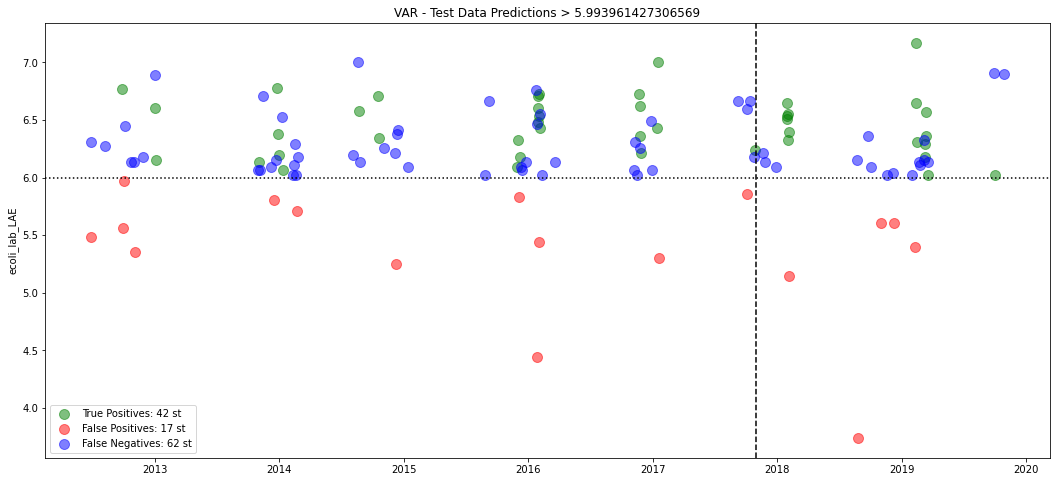

In [24]:
# Plot Performance on high levels.

threshold = 400
if log_scale_microbial_feats:
    threshold = np.log1p(threshold)

y_merged = np.append(y_train, y_test)
y_merged_var = np.append(var_y_train, var_y_test)
merged_dates = np.append(train_dates, test_dates)

tp_mask = (y_merged > threshold) * (y_merged_var > threshold)
fp_mask = (y_merged < threshold) * (y_merged_var > threshold)
fn_mask = (y_merged > threshold) * (y_merged_var < threshold)

plt.figure(figsize=(18, 8), facecolor='w')
plt.scatter(merged_dates[tp_mask], y_merged[tp_mask], color='green', s=100, alpha=0.5, label='True Positives: ' + str(sum(tp_mask)) + ' st')
plt.scatter(merged_dates[fp_mask], y_merged[fp_mask], color='red', s=100, alpha=0.5, label='False Positives: ' + str(sum(fp_mask)) + ' st')
plt.scatter(merged_dates[fn_mask], y_merged[fn_mask], color='blue', s=100, alpha=0.5, label='False Negatives: ' + str(sum(fn_mask)) + ' st')
plt.axvline(x=test_dates[0], color='black', linestyle='dashed')
plt.axhline(y=threshold, color='black', linestyle='dotted')
plt.ylabel(target_label)
plt.title('VAR - Test Data Predictions > ' + str(threshold))
plt.legend()
plt.savefig(img_path + 'VAR/threshold_plot.png', bbox_inches='tight', transparent=False)
plt.show()